# Non-Parametric-Learners

## kNN and Decision Trees

### Jonathan Torrez
#### January 30, 2017

*CREDITS (based on the notes and slides of Ryan Henning, Giovanna Thron, and Cary Goltermann)*

## Lecture Objectives [morning-kNN]

* **Describe** difference betwween parametric and non-parametric learning
* **Describe** pros and cons of parametric and non-parametric learning
* **Explain** one analogy demonstrating basic intuition of kNN algorithm
* **Implement** pseudocode for kNN algorithm
* **Describe** effect of varying k (num_neigbors)
    * bias-variance tradeoff
* **Describe** pros and cons of kNN algorithm
* **Describe** curse of dimensionality
* **Explain** one analogy describing curse of dimensionality
* **State** common distance metrics used for kNN
* **Explain** importance of scaling for kNN
* **State** use case for kNN
* **Describe** variants of basic kNN algorithm

## Parametric vs. Non-Parametric Models

### Parametric Models

Example of parametric model
* normal distribution
What do we need to describe it?
* mean, standard deviation, that's it
   

 
Second example of parametric model
* Linear regression
    
You answer: what do we need to describe it?
* Coeffecients, intercept. 
* Finite number of parameters
    
 

## Properties of Parametric Models

1. Assumes an underlying form in the data 
2. Number of parameters needed to describe that form is ***fixed.***

## Properties of Non-Parametric Models

What do you think they are?

You do: contrast the pros and cons of these two types of models

## Pros-Cons of Parametric Models

## Pros-Cons of Non-parametric Models

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#seed random functions for reproducibility
np.random.seed(12345)

In [2]:
horse_weight = np.random.rand(100) * 1500.0 + 400.0      # lbs
horse_height = horse_weight/370 + np.random.normal(0, 0.5, horse_weight.shape) + 2  # ft

dog_weight = np.random.rand(40) * 500.0 + 10.0      # lbs
dog_height = dog_weight/300 + np.random.normal(0, 0.3, dog_weight.shape) + 0.5  # ft

In [3]:
def plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height):
    plt.plot(horse_weight, horse_height, 'ro', label='Horse')
    plt.plot(dog_weight, dog_height, 'bo', label='Dog')
    plt.title("Horse vs Dog")
    plt.xlabel("Weight (lbs)")
    plt.ylabel("Height (ft)")
    plt.legend(loc='upper left')
    plt.show()

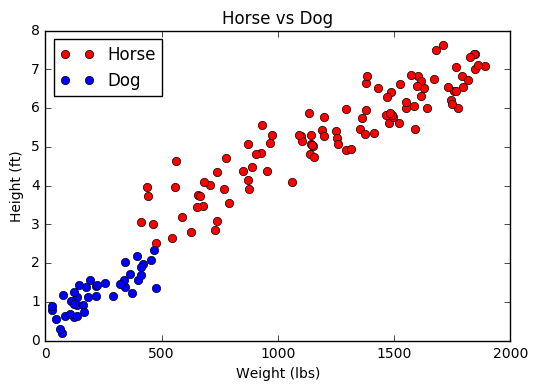

In [4]:
plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height)

## What if we get new data?

### Are they horses or dogs?

In [39]:
new_weights = [300, 500, 1200]
new_heights = [0.7, 2.3, 5.7]

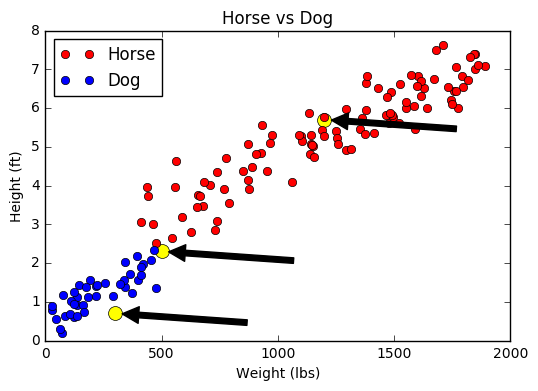

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.subplot(111)
plt.plot(new_weights, new_heights, marker='o', markersize=10, color="yellow", linestyle='None')

for new_x, new_y in zip(new_weights, new_heights):
    ax.annotate("",
                xy=(new_x, new_y), xycoords='data',
                xytext=(100, -7), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05))
plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height)


## Picking k

<img src="images/knn_simple.png" width=500 align="left"/>

In [ ]:
horse_weight = np.random.rand(50) * 1500.0 + 400.0      # lbs
horse_height = horse_weight/370 + np.random.normal(0, 0.5, horse_weight.shape) + 2  # ft

dog_weight = np.random.rand(30) * 800.0 + 10.0      # lbs
dog_height = dog_weight/300 + np.random.normal(0, 0.5, dog_weight.shape) + 1  # ft

plt.plot(horse_weight, horse_height, 'ro')
plt.plot(dog_weight, dog_height, 'bo')
plt.title("Horse vs Dog")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (ft)")
plt.show()

In [ ]:
X = np.column_stack((np.concatenate((horse_weight, dog_weight)),
                     np.concatenate((horse_height, dog_height))))
y = np.concatenate((np.zeros(horse_weight.shape),
                    np.ones(dog_weight.shape)))

In [ ]:
def plot_decision_boundary(X, y, k, scaled=True, title='Title', xlabel='xlabel', ylabel='ylabel'):
    """Plot the decision boundary of a kNN classifier.

    X must contain only 2 continuous features.

    Function modeled on sci-kit learn example.

    Parameters
    ----------
    X: numpy array
        Training data
    
    y: numpy array
        Target labels
    
    k: int
        The number of neighbors that get a vote.
        
    scaled: boolean, optional (default=True)
        If true scales the features, else uses scales in original units
    
    title: string, optional (default = 'Title')
        A string for the title of the plot
    
    xlabel: string, optional (default = 'xlabel')
        A string for the label on the x-axis of the plot
    
    ylabel: string, optional (default = 'ylabel')
        A string for the label on the y-axis of the plot
    

    Returns
    -------
    None
    """
    x_mesh_step_size = 0.5
    y_mesh_step_size = 0.05
    
    #Hard code in colors for classes, one class in red, one in blue
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    #Build a kNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    
    if scaled:
        #Build pipeline to scale features
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X, y)
    else:
        clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    feature_1 = X[:, 0]
    feature_2 = X[:, 1]
    x_min, x_max = feature_1.min() - 1, feature_1.max() + 1
    y_min, y_max = feature_2.min() - 1, feature_2.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_mesh_step_size),
                         np.arange(y_min, y_max, y_mesh_step_size))
    dec_boundary = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    dec_boundary = dec_boundary.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, dec_boundary, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(feature_1, feature_2, c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.title(title + ", k={0}, scaled={1}".format(k, scaled))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
title = 'Horse vs. Dog'
xlabel = 'Weight (lbs)'
ylabel = 'Height (ft)'

In [ ]:
plot_decision_boundary(X, y, k=5, title=title, xlabel=xlabel, ylabel=ylabel, scaled=False)

In [ ]:
plot_decision_boundary(X, y, 5, scaled=True)

## Weighted Voting

<img src="images/weighted_knn.png" width=500 align="left"/>

## Regression kNN

<img src="images/regression_knn.png" width=500 align="left"/>

## Morning Exercise Objectives [morning-kNN]
Reinforces the following objectives

* **Implement** pseudocode for kNN algorithm
    * Writing a class that implements the kNN algorithm
* **State** common distance metrics used for kNN
    * Writing code that calculates two most common
* **Describe** effect of varying k (num_neigbors)
    * Cross validating to choose k
    * Plotting decision boundary can visualize the effect
* **Explain** importance of scaling for kNN
    * Plotting decision boundary can visualize the effect

## Objectives [afternoon-DT]

* **Explain** one analogy demonstrating intuition of decision tree algorithm
* **Describe** common measures for making splits in a decision tree
    * Classification
    * Regression
* **State** difference between how decision tree and regresssion tree make final predictions
* **Demonstrate** calculations to perform a split by hand, given data
* **Draw** graph of impurity function
* **Demonstrate** concept of recursion and **relate** it to decision trees
* **Implement** pseudocode for decision tree algorit
* **Analyze** prediction metrics for overfitting
* **Explain** methods for picking "best" tree
* **State** pruning techniques and pros/cons of each
    * Pre-pruning
    * Post-pruning
* **Demonstrate** use of cost penalty for post-pruning
* **Describe** pros/cons of decision tree algorithm

## Pair Exercise Objectives [afternoon-DT]
Reinforces the following objectives

* **Implement** pseudocode for decision tree algorithm
    * Writing code that implements CART algorithm
* **Explain** one analogy demonstrating intuition of decision tree algorithm
* **Describe** common measures for making splits in a decision tree
    * Classification
        * Writing code to calculate entropy and Gini
* **Demonstrate** concept of recursion and **relate** it to decision trees
    * * Writing code that implements CART algorithm
    
#### Extra Credit 1
* **State** pruning techniques and pros/cons of each
    * Pre-pruning
        * Writing code to implement pre-pruning
    * Post-pruning
        * Writing code to implement post-pruning
* **Demonstrate** use of cost penalty for post-pruning
    * Writing code to implement post-pruning
        
#### Extra Credit 2
* **Describe** common measures for making splits in a decision tree
    * Regression
        * Writing code to implement regression tree

## Distance Metrics

### Euclidean Distance

Straight line, L2

*Euclidean* distance is the distance metric you've probably heard of before:

$$ d(\mathbf{a}, \mathbf{b}) = ||\mathbf{a} - \mathbf{b}|| \ = \sqrt{\sum (a_i - b_i)^2} $$

### Cosine Similarity

Angle

*Cosine* similarity is another commonly used distance metric. It's measuring the angle between the two vectors.

$$ d(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}|| ||\mathbf{b}||} $$

### Manhattan Distance

City blocks, L1

$$\sum_i |a_i - b_i|$$

### Shannon Entropy

$$H(X) = E[I(X)] = E[log_2(\tfrac{1}{P(X)})]$$

$$= -E[log_2(P(X))]$$

$$H(X) = - \sum_i p_i log_2(p_i)$$


### Information Gain

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$


### Gini Index

$$\text{Gini}(S) = 1 - \sum_{i \in S} p_i^2$$

$$\text{IG}(S, C) = \text{Gini}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Gini}(C_i)$$


### Weighted Voting

$$\frac{1}{d_i}$$

### k start

$$\sqrt{n}$$

### Hypercube stuff

$$ lim_{d \rightarrow \infty} \frac{V_{sphere}(R, d)}{V_{cube}(R, d)} = lim_{d \rightarrow \infty} \frac{\frac{\pi^{d/2}R^d}{\Gamma(d/2+1)}}{(2R)^d} = lim_{d \rightarrow \infty} \frac{\pi^{d/2}}{2^d\Gamma(d/2 + 1)} = 0 $$